# Time series forecasting with ARIMA

In this notebook, we demonstrate how to:
- prepare time series data for training an ARIMA time series forecasting model
- implement a simple ARIMA model to forecast the next HORIZON steps ahead (time *t+1* through *t+HORIZON*) in the time series
- evaluate the model 


The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [81]:
!pip install statsmodels

In [82]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [83]:
energy = load_data('./data')[['load']]
energy.head(10)

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"
2012-01-01 05:00:00,"2,453.00"
2012-01-01 06:00:00,"2,560.00"
2012-01-01 07:00:00,"2,719.00"
2012-01-01 08:00:00,"2,916.00"
2012-01-01 09:00:00,"3,105.00"


Plot all available load data (January 2012 to Dec 2014)

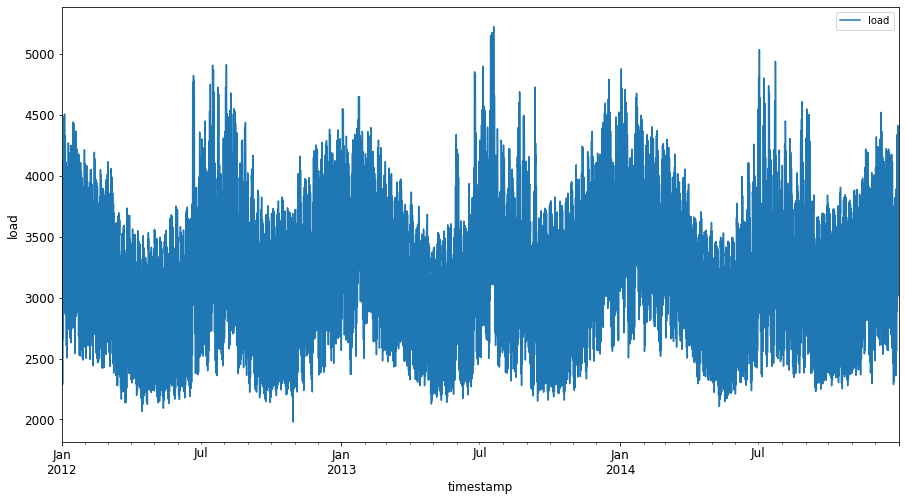

In [84]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Create training and testing data sets


In [85]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'    

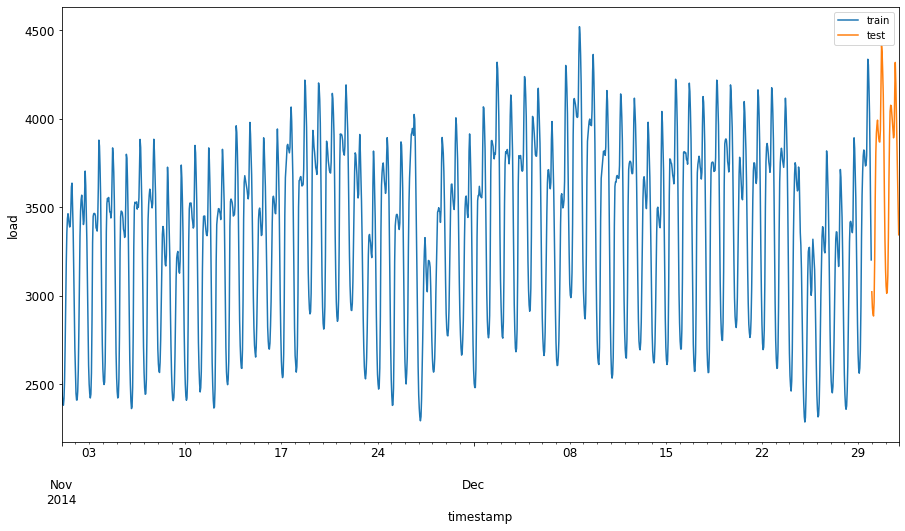

In [86]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [87]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [88]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
2014-11-01 00:00:00,0.10
2014-11-01 01:00:00,0.07
2014-11-01 02:00:00,0.05
2014-11-01 03:00:00,0.04
2014-11-01 04:00:00,0.06
2014-11-01 05:00:00,0.10
2014-11-01 06:00:00,0.19
2014-11-01 07:00:00,0.31
2014-11-01 08:00:00,0.40
2014-11-01 09:00:00,0.48


Original vs scaled data:

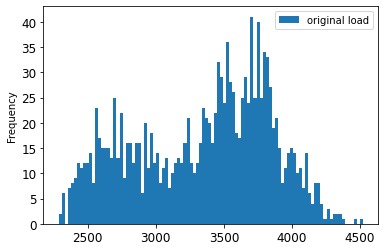

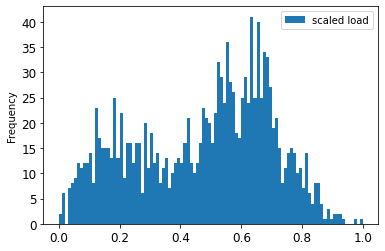

In [89]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

Let's also scale the test data

In [90]:
test['load'] = scaler.transform(test)
test.head()

,load
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


## Implement ARIMA method

In [91]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [93]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.45318D+00    |proj g|=  2.50788D+00


 This problem is unconstrained.



At iterate    5    f= -2.45390D+00    |proj g|=  4.50193D-01

At iterate   10    f= -2.45541D+00    |proj g|=  1.49646D+00

At iterate   15    f= -2.45565D+00    |proj g|=  5.89642D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     27      1     0     0   2.844D-02  -2.456D+00
  F =  -2.4556536226532630     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log

## Evaluate the model

Create a test data point for each HORIZON step.

In [94]:
test_shifted = test.copy()

for t in range(1, HORIZON+1):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2,load+3
2014-12-30 00:00:00,0.33,0.29,0.27,0.27
2014-12-30 01:00:00,0.29,0.27,0.27,0.30
2014-12-30 02:00:00,0.27,0.27,0.30,0.41
2014-12-30 03:00:00,0.27,0.30,0.41,0.57
2014-12-30 04:00:00,0.30,0.41,0.57,0.68


Make predictions on the test data

In [99]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

# let's user simpler model for demonstration
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON+1)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41942D+00    |proj g|=  1.50341D+00


 This problem is unconstrained.



At iterate    5    f= -2.41971D+00    |proj g|=  5.00564D-01

At iterate   10    f= -2.42249D+00    |proj g|=  2.36045D-01

At iterate   15    f= -2.42255D+00    |proj g|=  2.72197D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -2.42282D+00    |proj g|=  4.05307D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-1.714E-08  -gs= 3.691E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22    100      3     1     0   1.363D-02  -2.423D+00
  F =  -2.4228185698999325     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28 0.29] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323, 0.26812891674127126]



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41939D+00    |proj g|=  1.51571D+00

At iterate    5    f= -2.41975D+00    |proj g|=  3.05038D-01


 This problem is unconstrained.



At iterate   10    f= -2.42262D+00    |proj g|=  4.03318D-02

At iterate   15    f= -2.42262D+00    |proj g|=  3.31965D-02

At iterate   20    f= -2.42262D+00    |proj g|=  9.67282D-03

At iterate   25    f= -2.42278D+00    |proj g|=  8.23940D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f= -2.42278D+00    |proj g|=  5.32895D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     84      2     0     0   5.329D-03  -2.423D+00
  F =  -2.4227773617326398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3  0.34] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42057D+00    |pro


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -2.42388D+00    |proj g|=  6.86263D-03
  ys=-2.122E-12  -gs= 1.158E-11 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     98      3     1     0   7.145D-03  -2.424D+00
  F =  -2.4238797046085039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32 0.42] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42198D+00    |proj g|=  8.36871D-01

At iterate    5    f= -2.42207D+00    |pr

 This problem is unconstrained.



At iterate    5    f= -2.42761D+00    |proj g|=  1.28108D+00

At iterate   10    f= -2.42813D+00    |proj g|=  1.14965D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     26      1     0     0   6.507D-02  -2.428D+00
  F =  -2.4281299217408261     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54 0.65] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exa

 This problem is unconstrained.



At iterate    5    f= -2.42773D+00    |proj g|=  6.70957D-01

At iterate   10    f= -2.43174D+00    |proj g|=  9.71137D-01

At iterate   15    f= -2.43184D+00    |proj g|=  1.34708D-02

At iterate   20    f= -2.43202D+00    |proj g|=  2.44061D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     81      2     0     0   1.346D-02  -2.432D+00
  F =  -2.4320359948721992     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66 0.74] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368, 0.7309758281110115]



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.45302D+00    |proj g|=  2.36751D-01


 This problem is unconstrained.



At iterate    5    f= -2.45313D+00    |proj g|=  8.76462D-01

At iterate   10    f= -2.45592D+00    |proj g|=  4.47503D-01

At iterate   15    f= -2.45594D+00    |proj g|=  1.26598D-02

At iterate   20    f= -2.45596D+00    |proj g|=  1.20783D-02

At iterate   25    f= -2.45604D+00    |proj g|=  5.08466D-01

At iterate   30    f= -2.45607D+00    |proj g|=  1.41293D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     40      1     0     0   1.431D-02  -2.456D+00
  F =  -2.4560651421758215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75

 This problem is unconstrained.



At iterate    5    f= -2.45832D+00    |proj g|=  7.54452D-01

At iterate   10    f= -2.46104D+00    |proj g|=  1.13770D+00

At iterate   15    f= -2.46116D+00    |proj g|=  6.05033D-02

At iterate   20    f= -2.46118D+00    |proj g|=  2.83252D-02

At iterate   25    f= -2.46125D+00    |proj g|=  2.57130D-01

At iterate   30    f= -2.46128D+00    |proj g|=  1.05648D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     51      1     0     0   1.056D-03  -2.461D+00
  F =  -2.4612773455222370     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.46194D+00    |proj g|=  1.17532D+00

At iterate    5    f= -2.46209D+00    |proj g|=  4.40744D-01

At iterate   10    f= -2.46398D+00    |proj g|=  2.41425D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     19      1     0     0   1.775D-02  -2.465D+00
  F =  -2.4646583010793863     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 08:00:00
9 : predicted = [0.75 0.8  0.82 0.82] expected = [0.7309758281110115, 0.7511190689346463, 0.763

 This problem is unconstrained.



At iterate    5    f= -2.47481D+00    |proj g|=  3.68345D-01

At iterate   10    f= -2.47633D+00    |proj g|=  2.26482D+00

At iterate   15    f= -2.47689D+00    |proj g|=  1.02275D-02

At iterate   20    f= -2.47695D+00    |proj g|=  1.88640D-02

At iterate   25    f= -2.47697D+00    |proj g|=  4.38279D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     45      1     0     0   8.354D-03  -2.477D+00
  F =  -2.4769653304940942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 09:00:00
10 : predicted = [0.76 0.78 0.78 0.77] expected = [0.7511190689346463, 0.7636526410026856, 0.

 This problem is unconstrained.



At iterate    5    f= -2.47446D+00    |proj g|=  3.70272D-01

At iterate   10    f= -2.47666D+00    |proj g|=  3.68982D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     32      1     0     0   3.025D-02  -2.477D+00
  F =  -2.4766790705909720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 10:00:00
11 : predicted = [0.76 0.75 0.74 0.73] expected = [0.7636526410026856, 0.7381378692927483, 0.7188898836168307, 0.7090420769919425]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47425D+00    |proj g|=  1.98710D+00

At iterate    5    f= -2.47465D+00    |pro

 This problem is unconstrained.



At iterate    5    f= -2.47302D+00    |proj g|=  3.73010D-01

At iterate   10    f= -2.47526D+00    |proj g|=  2.24601D-01
  ys=-2.607E-11  -gs= 4.134E-11 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -2.47527D+00    |proj g|=  3.04083D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     42      1     1     0   3.041D-02  -2.475D+00
  F =  -2.4752715914226688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 12:00:00
13 : predicted = [0.7  0.68 0.69 0.72] expected = [0.7188898836168307, 0.7090420769919425, 0.7081468218442255, 0.7385854968666068]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47219D+00    |pro


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     62      2     0     0   3.281D-02  -2.475D+00
  F =  -2.4751155788669172     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 13:00:00
14 : predicted = [0.72 0.73 0.76 0.88] expected = [0.7090420769919425, 0.7081468218442255, 0.7385854968666068, 0.8478066248880931]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47247D+00    |proj g|=  2.06965D+00

At iterate    5    f= -2.47290D+00    |proj g|=  4.16108D-01

At iterate   10    f= -2.47463D+00    |proj g|=  2.51081D+00

At iterate   15    f= -2.47534D+00    |proj g|=  2.14054D-02

At iterate   20    f= -2.47537D+00    |proj g|=  2.46302D-01

At iterate   25    f= -2.47542D+00    |proj g|=  2.46054D-01

At iterate   30    f= -2.47542D+00    |proj g|=  5.41548D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f= -2.47305D+00    |proj g|=  1.14681D+00

At iterate   10    f= -2.47548D+00    |proj g|=  1.63458D-01

At iterate   15    f= -2.47551D+00    |proj g|=  1.54294D-02

At iterate   20    f= -2.47554D+00    |proj g|=  8.51589D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     68      2     0     0   1.495D-03  -2.476D+00
  F =  -2.4755571790928355     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 15:00:00
16 : predicted = [0.73 0.85 0.97 0.95] expected = [0.7385854968666068, 0.8478066248880931, 0.9516562220232765, 0.934198746642793]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47454D+00    |proj g|=  1.83674D+00

At iterate    5    f= -2.47488D+00    |proj

 This problem is unconstrained.



At iterate    5    f= -2.47534D+00    |proj g|=  4.67116D-01

At iterate   10    f= -2.47723D+00    |proj g|=  2.00118D+00

At iterate   15    f= -2.47765D+00    |proj g|=  1.32823D-02

At iterate   20    f= -2.47769D+00    |proj g|=  1.61726D-01

At iterate   25    f= -2.47773D+00    |proj g|=  1.63493D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     89      2     0     0   1.787D-02  -2.478D+00
  F =  -2.4777328090947539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 17:00:00
18 : predicted = [0.94 0.92 0.86 0.8 ] expected = [0.9516562220232765, 0.934198746642793, 0.8876454789615038, 0.8294538943598924]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47581D+00    |proj g|=  1.98036D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -2.47620D+00    |proj g|=  5.08252D-01

At iterate   10    f= -2.47813D+00    |proj g|=  1.42282D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     59      2     0     0   3.443D-02  -2.478D+00
  F =  -2.4783155403487278     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2014-12-30 18:00:00
19 : predicted = [0.94 0.89 0.82 0.71] expected = [0.934198746642793, 0.8876454789615038, 0.8294538943598924, 0.7197851387645477]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47585D+00    |proj g|=  1.98205D+00

At iterate    5    f= -2.47624D+00    |proj


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     65      2     0     0   1.279D-02  -2.478D+00
  F =  -2.4784305928324923     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 19:00:00
20 : predicted = [0.88 0.82 0.71 0.57] expected = [0.8876454789615038, 0.8294538943598924, 0.7197851387645477, 0.5747538048343777]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47584D+00    |proj g|=  1.98236D+00

At iterate    5    f= -2.47623D+00    |pro

 This problem is unconstrained.



At iterate    5    f= -2.47668D+00    |proj g|=  7.22532D-01

At iterate   10    f= -2.47867D+00    |proj g|=  1.76459D-02

At iterate   15    f= -2.47868D+00    |proj g|=  3.27991D-02

At iterate   20    f= -2.47870D+00    |proj g|=  1.31518D-01

At iterate   25    f= -2.47874D+00    |proj g|=  3.56529D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     81      2     0     0   3.565D-03  -2.479D+00
  F =  -2.4787420745788977     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2014-12-30 21:00:00
22 : predicted = [0.72 0.58 0.47 0.39] expected = [0.7197851387645477, 0.5747538048343777, 0.4592658907788718, 0.3858549686660697]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47619D+00    |proj g|=  2.01926D+00

At iterate    5    f= -2.47660D+00    |pro


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     39      1     0     0   4.418D-03  -2.479D+00
  F =  -2.4788136349332017     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 22:00:00
23 : predicted = [0.58 0.47 0.39 0.35] expected = [0.5747538048343777, 0.4592658907788718, 0.3858549686660697, 0.34377797672336596]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47623D+00    |proj g|=  2.02380D+00

At iterate    5    f= -2.47663D+00    |pr

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47622D+00    |proj g|=  2.02204D+00

At iterate    5    f= -2.47663D+00    |proj g|=  4.40399D-01

At iterate   10    f= -2.47861D+00    |proj g|=  6.93887D-01

At iterate   15    f= -2.47881D+00    |proj g|=  5.67747D-02
  ys=-4.837E-10  -gs= 9.010E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     69      2     1     0   3.287D-02  -2.479D+00
  F =  -2.4788071430960050     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2014-12-31 00:00:00
25 : predicted = [0.38 0.34 0.33 0.32] expected = [0.3858549686660697, 0.34377797672336596, 0.32542524619516544, 0.33034914950760963]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47614D+00    |proj g|=  2.00057D+00

At iterate    5    f= -2.47656D+00    |


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     78      2     0     0   2.094D-02  -2.479D+00
  F =  -2.4787583392322947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 01:00:00
26 : predicted = [0.36 0.34 0.34 0.38] expected = [0.34377797672336596, 0.32542524619516544, 0.33034914950760963, 0.3706356311548791]



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47614D+00    |proj g|=  1.99668D+00


 This problem is unconstrained.



At iterate    5    f= -2.47653D+00    |proj g|=  3.66901D-01

At iterate   10    f= -2.47809D+00    |proj g|=  2.24444D+00

At iterate   15    f= -2.47868D+00    |proj g|=  2.63075D-02

At iterate   20    f= -2.47875D+00    |proj g|=  4.81122D-02

At iterate   25    f= -2.47875D+00    |proj g|=  1.83485D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     58      1     0     0   1.835D-02  -2.479D+00
  F =  -2.4787497011028790     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 02:00:00
27 : predicted = [0.32 0.32 0.35 0.46] expected = [0.32542524619516544, 0.33034914950760963, 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47671D+00    |proj g|=  1.93928D+00


 This problem is unconstrained.



At iterate    5    f= -2.47709D+00    |proj g|=  3.91680D-01

At iterate   10    f= -2.47903D+00    |proj g|=  2.10161D-01

At iterate   15    f= -2.47920D+00    |proj g|=  8.97482D-03

At iterate   20    f= -2.47924D+00    |proj g|=  6.23145D-02

At iterate   25    f= -2.47924D+00    |proj g|=  1.18366D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     40      1     0     0   1.184D-02  -2.479D+00
  F =  -2.4792372511307410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 03:00:00
28 : predicted = [0.32 0.36 0.47 0.63] expected = [0.33034914950760963, 0.3706356311548791, 0

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47680D+00    |proj g|=  1.96853D+00

At iterate    5    f= -2.47718D+00    |proj g|=  3.70709D-01

At iterate   10    f= -2.47924D+00    |proj g|=  1.31867D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     52      2     0     0   1.460D-02  -2.479D+00
  F =  -2.4792618517069758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-31 04:00:00
29 : predicted = [0.37 0.48 0.65 0.75] expected = [0.3706356311548791, 0.470008952551477, 0.6145926589077886, 0.7247090420769919]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47675D+00    |proj g|=  1.91395D+00


 This problem is unconstrained.



At iterate    5    f= -2.47711D+00    |proj g|=  3.52215D-01

At iterate   10    f= -2.47901D+00    |proj g|=  1.56768D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     21      1     0     0   1.306D-02  -2.479D+00
  F =  -2.4792591005440032     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 05:00:00
30 : predicted = [0.48 0.64 0.75 0.8 ] expected = [0.470008952551477, 0.6145926589077886, 0.7247090420769919, 0.786034019695613]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f= -2.47727D+00    |proj g|=  3.68324D-01

At iterate   10    f= -2.47919D+00    |proj g|=  1.43057D+00

At iterate   15    f= -2.47938D+00    |proj g|=  2.54958D-02

At iterate   20    f= -2.47944D+00    |proj g|=  2.57447D-02

At iterate   25    f= -2.47944D+00    |proj g|=  2.67338D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     73      2     0     0   2.628D-02  -2.479D+00
  F =  -2.4794384832100911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 06:00:00
31 : predicted = [0.63 0.73 0.79 0.81] expected = [0.6145926589077886, 0.7247090420769919, 0.786034019695613, 0.8012533572068039]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47673D+00    |proj g|=  1.92357D+00

At iterate    5    f= -2.47710D+00    |proj g|=  4.18150D-01

At iterate   10    f= -2.47868D+00    |proj g|=  2.30064D+00

At iterate   15    f= -2.47921D+00    |proj g|=  2.43921D-02

At iterate   20    f= -2.47922D+00    |proj g|=  3.58191D-02

At iterate   25    f= -2.47928D+00    |proj g|=  1.65580D-01

At iterate   30    f= -2.47928D+00    |proj g|=  1.85797D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f= -2.47726D+00    |proj g|=  3.68642D-01

At iterate   10    f= -2.47873D+00    |proj g|=  2.22035D+00

At iterate   15    f= -2.47929D+00    |proj g|=  1.17177D-02

At iterate   20    f= -2.47935D+00    |proj g|=  5.91209D-02
  ys=-4.250E-09  -gs= 8.301E-08 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f= -2.47935D+00    |proj g|=  5.78090D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     61      1     1     0   5.781D-02  -2.479D+00
  F =  -2.4793541605819605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 08:00:00
33 : predicted = [0.79 0.82 0.83 0.81] expected = [0.786034019695613, 0.8012533572068039, 0.7994628469113696, 0.780214861235452]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47736D+00    |proj 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.47829D+00    |proj g|=  3.41610D-01

At iterate   10    f= -2.48037D+00    |proj g|=  9.91250D-02

At iterate   15    f= -2.48041D+00    |proj g|=  3.39632D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -2.48043D+00    |proj g|=  8.73631D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     39      1     0     0   8.736D-04  -2.480D+00
  F =  -2.4804277282476082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 10:00:00
35 : predicted = [0.8  0.78 0.76 0.75] expected = [0.7994628469113696, 0.780214861235452, 0.7587287376902416, 0.7367949865711727]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47788D+00    |proj

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47767D+00    |proj g|=  1.89557D+00

At iterate    5    f= -2.47803D+00    |proj g|=  5.52827D-01

At iterate   10    f= -2.48018D+00    |proj g|=  3.15775D-02

At iterate   15    f= -2.48019D+00    |proj g|=  7.28922D-02

At iterate   20    f= -2.48024D+00    |proj g|=  4.03181D-02

At iterate   25    f= -2.48026D+00    |proj g|=  2.66339D-02

At iterate   30    f= -2.48026D+00    |proj g|=  1.88981D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f= -2.47829D+00    |proj g|=  5.50248D-01

At iterate   10    f= -2.48001D+00    |proj g|=  1.36974D+00

At iterate   15    f= -2.48050D+00    |proj g|=  1.23945D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-1.559E-11  -gs= 5.189E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     75      3     1     0   7.571D-03  -2.480D+00
  F =  -2.4804978870406313     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2014-12-31 13:00:00
38 : predicted = [0.75 0.75 0.78 0.89] expected = [0.7367949865711727, 0.7188898836168307, 0.7273948075201431, 0.8299015219337511]



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47799D+00    |proj g|=  1.88498D+00

At iterate    5    f= -2.47833D+00    |proj g|=  3.89752D-01

At iterate   10    f= -2.48033D+00    |proj g|=  1.50550D+00

At iterate   15    f= -2.48054D+00    |proj g|=  1.38503D-02
  ys=-3.940E-07  -gs= 7.542E-07 BFGS update SKIPPED


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f= -2.48054D+00    |proj g|=  6.76348D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     51      1     1     0   6.763D-02  -2.481D+00
  F =  -2.4805420620341851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 14:00:00
39 : predicted = [0.73 0.75 0.87 0.98] expected = [0.7188898836168307, 0.7273948075201431, 0.8299015219337511, 0.909579230080573]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47785D+00    |proj g|=  1.77092D+00

At iterate    5    f= -2.47815D+00    |proj g|=  3.53256D-01

At iterate   10    f= -2.48041D+00    |proj g|=  2.52881D-01

At iterate   15    f= -2.48047D+00    |proj g|=  4.25982D-02

At iterate   20    f= -2.48048D+00    |proj g|=  8.84217D-02

At iterate   25    f= -2.48049D+00    |proj g|=  8.98063D-02

At iterate   30    f= -2.48050D+00    |proj g|=  6.52910D-02
  ys=-2.018E-07  -gs= 4.158E-08 BFGS update SKIPPED

At iterate   35    f= -2.48051D+00    |proj g|=  1.68844D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-31 15:00:00
40 : predicted = [0.74 0.85 0.96 0.95] expected = [0.7273948075201431, 0.8299015219337511, 0.909579230080573, 0.855863921217547]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47838D+00    |proj g|=  1.83840D+00


 This problem is unconstrained.



At iterate    5    f= -2.47871D+00    |proj g|=  3.63060D-01

At iterate   10    f= -2.48046D+00    |proj g|=  2.30629D+00

At iterate   15    f= -2.48097D+00    |proj g|=  1.65840D-01

At iterate   20    f= -2.48098D+00    |proj g|=  5.90779D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     38      1     0     0   3.551D-02  -2.481D+00
  F =  -2.4809922528864514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 16:00:00
41 : predicted = [0.83 0.94 0.93 0.88] expected = [0.8299015219337511, 0.909579230080573, 0.855863921217547, 0.7721575649059982]
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



At iterate    5    f= -2.47942D+00    |proj g|=  3.91042D-01

At iterate   10    f= -2.48158D+00    |proj g|=  9.54069D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     25      1     0     0   1.321D-02  -2.482D+00
  F =  -2.4816740232701244     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 17:00:00
42 : predicted = [0.94 0.93 0.88 0.82] expected = [0.909579230080573, 0.855863921217547, 0.7721575649059982, 0.7023276633840643]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47776D+00    |proj g|=  1.89886D+00

At iterate    5    f= -2.47812D+00    |proj g|=  4.21911D-01

At iterate   10    f= -2.47982D+00    |proj g|=  2.37040D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     22      1     0     0   1.070D-02  -2.480D+00
  F =  -2.4804056218650330     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 18:00:00
43 : predicted = [0.87 0.82 0.77 0.66] expected = 

 This problem is unconstrained.



At iterate    5    f= -2.47739D+00    |proj g|=  3.83344D-01

At iterate   10    f= -2.47894D+00    |proj g|=  2.42868D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -2.47969D+00    |proj g|=  9.33829D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     83      3     0     0   9.338D-03  -2.480D+00
  F =  -2.4796939099209014     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2014-12-31 19:00:00
44 : predicted = [0.79 0.73 0.63 0.49] expected = [0.7721575649059982, 0.7023276633840643, 0.6195165622202325, 0.5425246195165621]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47692D+00    |proj g|=  1.83520D+00


 This problem is unconstrained.



At iterate    5    f= -2.47725D+00    |proj g|=  3.52916D-01

At iterate   10    f= -2.47917D+00    |proj g|=  1.89581D+00

At iterate   15    f= -2.47952D+00    |proj g|=  1.46474D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     25      1     0     0   1.465D-02  -2.480D+00
  F =  -2.4795157930919371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 20:00:00
45 : predicted = [0.7  0.59 0.46 0.35] expected = [0.7023276633840643, 0.6195165622202325, 0.5425246195165621, 0.4735899731423454]
CPU times: user 5min 3s, sys: 3min 5s, total: 8min 8s
Wall time: 1min 17s


Compare predictions to actual load

In [103]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+2)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-12-30 00:00:00,t+1,"3,009.18","3,023.00"
1,2014-12-30 01:00:00,t+1,"2,955.79","2,935.00"
2,2014-12-30 02:00:00,t+1,"2,900.11","2,899.00"
3,2014-12-30 03:00:00,t+1,"2,917.78","2,886.00"
4,2014-12-30 04:00:00,t+1,"2,947.03","2,963.00"


Compute the **mean absolute percentage error (MAPE)** over all predictions

$$MAPE = \frac{1}{n} \sum_{t=1}^{n}|\frac{actual_t - predicted_t}{actual_t}|$$

In [104]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.01
t+2   0.01
t+3   0.02
t+4   0.02
Name: APE, dtype: float64


In [105]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  0.5420260186331665 %


In [106]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

Multi-step forecast MAPE:  1.286865092111503 %


Plot the predictions vs the actuals for the first week of the test set

No handles with labels found to put in legend.


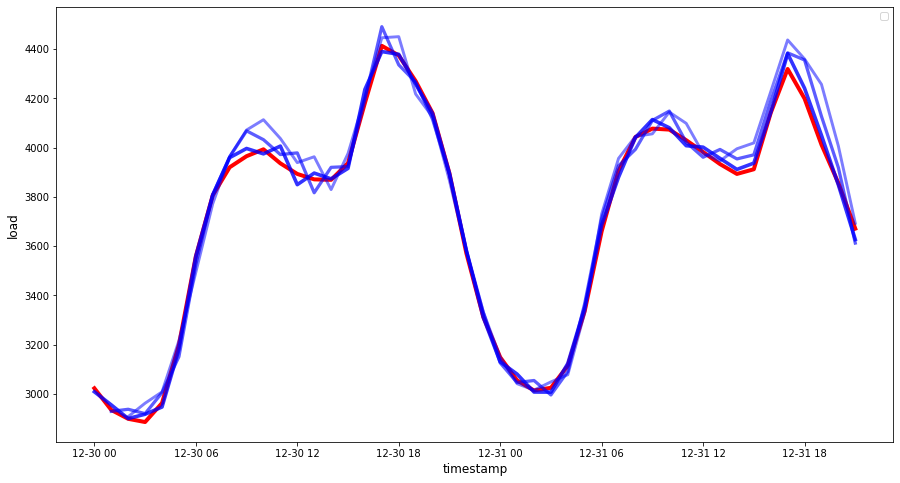

In [19]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()